# Skip-gram Implementation Project

Welcome to my skip gram notebook! Here, we'll uncover the mystery behind word embeddings by building a skip-gram model from scratch and see why such a simple model can create such interesting results!

## Introduction to Skip-gram

The  Skip-Gram  model  introduced  an  efficient  and  intuitive  way  to  create  word embeddings  with  various  positive  qualities.  With this model you could find so many common relationships between words, just by considering the context words appear in. The context in this case, is simply whatever words are nearby in the text you use for training. 
<br><br>
The model chooses to represet words as vectors that live in a high-dimensional space. These vectors are trained to be close to eachother if they typically appear in the same context, and far apart if they typically don't. This basically means they are a bunch of points, and the ones that are near to each other should be related words while the ones that are far apart should be unrelated.
<br><br>
Of course, the proper context for a given word must be learned in practice, such as in the transformer model, but the skip-gram model layed a smooth foundation for the expedited progress of natural language processing in the past 10 years.

## Project Goals

In this project, our main goals are:


1. **[Understanding Skip-gram](#understanding-skip-gram):** We will start by grasping the architecture of the skip-gram model along with its training objective. This will teach us how important a good training objective is and how it can create such fascinating results.

2. **[Data Preprocessing](#data-preprocessing):** Before diving into the model implementation, we will prepare our data. This step involves cleaning and organizing the text data to ensure it meets the training objective.

3. **[Model Implementation](#model-implementation):** We'll build the architecture as efficiently as we can, covering the output weights and the embeddings.
    - **[Forward and Backward Passes](#forward-and-backward-passes):** With the model implemented, we'll train it using our processed dataset and evaluate its performance. We will learn together how training happens in this model and how gradients are propagated!
<br><br>
4. **[Visualization](#visualization):** To gain insights into the model's output, we'll visualize the word embeddings in a lower-dimensional space. We will also measure the predicted distribution across all words and see how it changes over time.

5. **[Discussion](#discussion):** Lastly, we'll discuss the efficiency concerns of the model and the limitations in training both in this way and on such a limited dataset.


<a id="understanding-skip-gram"></a>
## Understanding Skip-gram
***
The skip-gram model takes in an emedding matrix, passes it through one layer and compares it to a target (the context). The embedding matrix is essentially all the word vectors we have, one per word, and we will select the current word vector based on the current word in the text. 
<br><br> The context is also a vector. It is has one value per word, and this value is 0 if the word is not in the context and 1 if it is.

So if I had: 
- "It is nice outside today" and current word is "nice" 
- $\rightarrow$ Get the word vector for "nice" from the embedding matrix
- $\rightarrow$ Pass it through the skip-gram model
- $\rightarrow$ Get output vector with values between (0, 1). 0 means not in context and 1 means in context.
- $\rightarrow$ Compare to ground truth (context) which has a 1 exactly where the surrounding words "It" "is" "outside" "today" are, and 0 everywhere else.

<a id="data-preprocessing"></a>
## Data Loading and Preprocessing 
***
So, before I get ahead of myself, let's prepare the data. Here, we want to read in a corpus (text file). Ideally, this will be prepared with care so as to encourage good relationships by the model. In my case, since this is a refactor of my first implementation of this project, and GPT has since come out.......I'll ask it to give me a corpus that propotes semantically meaningful embeddings. I don't really know how its figuring that out, but if you're interested, I'll show a bit of it below.

1. First we read the file line by line. 
2. Then we will process the data to remove punctuation, stopwords and split into words.
    - We can use re to effeciently clean the punctuation and numbers from our text.
    - NLTK provides a nice collection of stopwords we can install, so we use those to get rid of our stopwords.
3. Lastly, we create our encoding, which maps our words to indices in our embedding matrix, so we can quickly choose the current word in the training process.

In [1]:
import re
import nltk
from nltk.corpus import stopwords
# for use in later visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

nltk.download('stopwords')

def get_data(filename):
    contents = []
    with open(filename, 'r') as f:
        lines = f.read()
    
    return lines

def process_data(text):
    stop_words = set(stopwords.words('english'))

    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    cleaned_text = text.strip()

    words = cleaned_text.split(' ')
    stop_words_removed = [word.lower() for word in words if word.lower() not in stop_words]

    return stop_words_removed

def display_text(text, words=None):
    print('-'*6 + f'\nCORPUS\n' + '-'*6)
    for i, line in enumerate(corpus.split('.')):
        print(line)

        if i > 5:
            break

    if words is not None:
        print()
        print('-'*5 + f'\nWORDS\n' + '-'*5)
        print(words[:10])

[nltk_data] Downloading package stopwords to
[nltk_data]     /mnt/c/Users/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
DATA_DIR = '../../data/'
FILE = 'corpus.txt'

filename = DATA_DIR + FILE

corpus = get_data(filename)
words = process_data(corpus)

Here you can see some of the original corpus, versus our list of words after preprocessing our data for training. We remove all punctuation, and filter out the stopwords. It's a fairly basic preprocessing stage, but good enough for the purposes of this project.

In [3]:
display_text(corpus, words)

------
CORPUS
------
In the heart of the bustling city, travelers gather to share stories of their adventures
 Each journey brings unique experiences and lessons, as explorers venture into uncharted territories


High in the mountains, where the air is crisp and the landscapes breathtaking, hikers navigate winding trails, uncovering hidden gems amidst the wilderness
 The echo of footsteps resonates through the valleys, connecting those who seek solace in nature


Along the coastline, waves kiss the shore, leaving behind a treasure trove of shells and secrets
 Sailors set sail on the vast sea, chasing the horizon with dreams of distant lands
 The ocean's expanse reflects the infinite possibilities of the world

-----
WORDS
-----
['heart', 'bustling', 'city', 'travelers', 'gather', 'share', 'stories', 'adventures', 'journey', 'brings']


### Tokenizer Class
Now I will create an encoding for the words, so each word gets a unique index. Then I will create our embedding matrix as a randomly initialized matrix, with one vector for each word.
- I mentioned we are using a high-dimensional vector for each word. 
- This dimensionality can be modified, as a hyper-parameter it's important to see how the dimensionality affects our performance!

In [4]:
# Tokenizer class is very simple, just getting the encodings for the words and maintaining the vocabulary
class Tokenizer():
    def __init__(self):
        self.vocab = []
        self.index_to_key = {}
        self.key_to_index = {}
    
    def fit(self, words):
        # get unique words
        vocab = set(words)
        # get index for each unique word and create forward and backward map
        self.index_to_key = {i : word for i, word in enumerate(vocab)}
        self.key_to_index = {word : i for i, word in enumerate(vocab)}
        self.vocab = list(vocab)

def encode_words(words, tokenizer):
    # encode the words as their indices for training
    encoding = [tokenizer.key_to_index[word] for word in words]

    return encoding


In [5]:
tokenizer = Tokenizer()
tokenizer.fit(words)
encoding = encode_words(words, tokenizer)

print('--------------'+'\nENCODED WORDS\n'+'--------------')
print('Words:', words[:10])
print('Encoding:', encoding[:10])

--------------
ENCODED WORDS
--------------
Words: ['heart', 'bustling', 'city', 'travelers', 'gather', 'share', 'stories', 'adventures', 'journey', 'brings']
Encoding: [153, 174, 112, 59, 5, 39, 24, 4, 140, 86]


### Dataset Creation
For our training set, we need a specific format. On each iteration, we will take the current word as input, and try to predict the surrounding words as output. So our training data has one input (the current word index) and one output (the surrounding words). The surrounding words are within a "window" of our input. This "window size" is also a hyper-parameter and can be adjusted.<br><br>
**Note:** The window size is the value of words we take in either direction, so the context is 2x the size.

In [6]:
import numpy as np

def one_hot(context_id, vocab_size):
    one_hot_vector = np.zeros(vocab_size)
    one_hot_vector[context_id] = 1.0
    
    return one_hot_vector

def create_dataset(encoding, tokenizer, window_size=2):
    dataset = []
    for i in range(len(encoding)):
        start = max(0, i - window_size)
        end = min(len(encoding), i + window_size + 1)

        context = encoding[start:i]
        context.extend(encoding[i+1:end])

        # target = one_hot(context, tokenizer)
        
        dataset.append({
            'input_id': encoding[i], 
            'context': [one_hot(context_id, len(tokenizer.vocab)) for context_id in context]
        })

    return dataset

In [7]:
WINDOW_SIZE = 2

dataset = create_dataset(encoding, tokenizer, window_size=WINDOW_SIZE)
dataset[10]

{'input_id': 72,
 'context': [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 

<a id="model-implementation"></a>
## Embeddings and Model Architecutre
***
The model architecture is basically one weight matrix. This matrix has the dimensions (embedding_dim, vocab_size), and is often refered to as the output word vectors. This is because the output vectors which refer to each word in the context move closer together, providing their own relationships. Besides this we have our word embeddings. This will be a matrix of dimensions (vocab_size, embedding_dim), where each word in the vocab has its own vector of size (, embedding_dim).

<!-- <div style="text-align: center;"> -->
<img src="imgs/skip-gram-architecture.png" alt="Skip Gram Architecture" width="400" height="500" style="border: 2px solid black; padding: 20px; background-color: white;">
<!-- </div> -->

- **Note:** In the original implementation, the embedding is abstracted away, giving rise to two weight matrices instead of one. This is because the input is a one-hot vector of the current word, so by performing matrix multiplication we get a unique weight vector from the first weight matrix (our embedding / hidden layer). The embedding is simply a more efficient implementation, opting out of the multiplication for simple indexing.
- **Also Note:** There are multiple output vectors! Don't worry, it's really pretty simple. Each context word gets assigned its own one-hot vector. When we multiply by the weight matrix to get our prediction, we simply compare the prediction against each context vector individually. We basically ask multiple times, do you think ***this*** word's related?

### SkipGramModel Class
Alright, so implementing the model is next. Let's make a simple class to hold our relevant states, so we can update the parameters and keep everything tidy.
- This class will hold the relevant parameters that the model should update during training. 
- This will contain our word vectors and our weights. 
- We also add fields for our callback, which store relevant information for later visualizations. 
    - This can be cool for getting an animated view of the training process!

**Key Features:**
1. Embedding and weight matrices
    - The embedding matrix and weight matrix will be initialized randomly to have values between -1 and 1. 
    - It's important to keep these small, as large values will cause unpredictable behavior in the model and severly hinder training.
2. SoftMax
    - This is our activation function for the output. When we multiply our matrices together, we get a value for each word. A larger value implies the model is more confident that a given word is in the context.
    - SoftMax normalizes this information, so that the entire vector becomes a probability distribution. This means that for each word, the model predicts the probability that the word is in the context.
3. Loss function
    - $E = -\log{p(w_I)}$
    - This simple equation takes the log probability of our predictions. There are various nice qualities about this, the most prominent being the ease of gradient descent calculations. 
    - This objective moves word vectors away from eachother if they don't appear in the same context and closer if they do.
***
<a id="forward-and-backward-passes"></a>
**Forward and Backward Passes:**
1. Predict
    - Performs the inner product of the matrices, giving us our prediction score.
    - Takes the prediction scores and normalizes them into a probability distribution with softmax.
2. Backward
    - Gradient descent takes the negative gradient and shifts the weight in this direction. By taking the negative gradient, we are trying to ski down the loss function and minimize the error.
    - This process can be broken down in three steps:
        1. Gradient of the loss function: This simply evaluates to the 'prediction - truth.' 
        - The nice properties show up! The gradient of that seemingly complex loss function is just prediction score minus 1 (if the word is in the context) and minus 0 (if its not). 
        - **Notice** 
            - If our predicted probability is close to 1 and we are wrong, then we get a relatively large positive value. 
            - If we predict close to 0 we are wrong, we get a large negative value. 
            - By doing this we will bring vectors close if they are 1, and push them away if they are 0. This push is proportional to the error (how far off from the truth we were). 
            - If we are right, then the push is tiny, and we don't mess much with that prediction anymore.
        

In [8]:
class SkipGramModel():
    def __init__(self, vocab_size, embedding_dim, target_id=0, learning_rate=0.001):
        self.embedding_matrix = np.random.uniform(-1, 1, (vocab_size, embedding_dim))
        self.weights = np.random.uniform(-1, 1, (embedding_dim, vocab_size))

        self.learning_rate = learning_rate

        self.target_id=target_id

        self.vectors_over_time = []
        self.predictions_over_time = []
        self.loss_curve = []
    
    @staticmethod
    def softmax(score):
        exp_scores = np.exp(score - np.max(score))
        return exp_scores / exp_scores.sum()
    
    def loss_fn(self, y_pred, context):
        epsilon = 1e-8
        loss = -np.sum(context * np.log(np.maximum(y_pred, epsilon)), axis=-1).mean()

        return loss
    
    # for predictions, we perform an inner product with the weights, then softmax the score to get a distribution we compare to ground truth context
    def predict(self, input_id):
        try:    
            score = np.dot(self.embedding_matrix[input_id], self.weights)
            y_pred = SkipGramModel.softmax(score)
        except:
            print(input_id)
            y_pred = np.zeros(self.embedding_matrix[input_id].shape)
       
        return y_pred

    # backward pass transfers the gradient from the prediction error (y_pred - context)
    # to the weights by performing an outer product with the current word embedding. 
    # this is then used to update the embedding vector by performing an inner product on the new weights with the error
    def backward(self, input_id, context, y_pred):
        for context_vector in context:
            # Calculate the error as the difference between the prediction and the true context word
            error = y_pred - context_vector
            
            # Update the output vectors (model weights)
            self.weights -= self.learning_rate * np.outer(self.embedding_matrix[input_id], error)

            # Update the input vectors (embedding vector)
            self.embedding_matrix[input_id] -= self.learning_rate * np.dot(self.weights, error)

    # updated when the model runs to get visualizations
    def update_model_states(self, word_vectors_2d=None, predictions=None, loss=None):
        if word_vectors_2d is not None:
            self.vectors_over_time.append(word_vectors_2d)
        if predictions is not None:
            self.predictions_over_time.append(predictions)
        if loss is not None:
            self.loss_curve.append(loss)
        

##### Model Training
The training is pretty straight-forward:
1. Get a prediction
2. Run the backward method to update the weights based on that prediction
3. Repeat for each word
4. Repeat steps (1-3) a ton of times

In [9]:
from sklearn.decomposition import TruncatedSVD, PCA

def train(model, training_data, epochs=100, verbose=True, reducer=None):
    for epoch in range(epochs+1):
        for sample in training_data:
            # get our input word and its current context
            input_id = sample['input_id']
            context = np.array(sample['context'])
            
            # predict the context and get the loss
            y_pred = model.predict(input_id)
            loss = model.loss_fn(y_pred, context)

            # update the weights and embeddings
            model.backward(input_id, context, y_pred)

        # every so often we add to our information about the model
        if reducer and epoch % 10 == 0:
            x = reducer.transform(model.embedding_matrix)
            model.update_model_states(word_vectors_2d=x)
        if epoch % 50 == 0 and verbose:
            print(f"Epoch: {epoch} - Loss: {loss}")
        
        model.update_model_states(predictions=model.predict(model.target_id), loss=loss)

Here we train our model, and watch as the loss decreases!

In [10]:
EMBEDDING_DIM = 32
EPOCHS = 300
LR = 0.005
TARGET_ID = tokenizer.key_to_index['treasure']

model = SkipGramModel(
    vocab_size=len(tokenizer.vocab), 
    embedding_dim=EMBEDDING_DIM,
    learning_rate=LR,
    target_id=TARGET_ID
)

train(model, epochs=EPOCHS, training_data=dataset)

Epoch: 0 - Loss: 6.899374157063807
Epoch: 50 - Loss: 1.8685289379037089
Epoch: 100 - Loss: 1.0152891701796782
Epoch: 150 - Loss: 0.8321771362749925
Epoch: 200 - Loss: 0.7761477863470809
Epoch: 250 - Loss: 0.7508901631362708
Epoch: 300 - Loss: 0.7368864616690564


I added this to fix a bug I was having. If you fit_transform PCA on each iteration of updates, you will find different principal components, so the movement of vectors will not be smooth. Instead, a solution is to fit the PCA to the trained embeddings, then simply transform on a new training cycle to capture the vector movement.

In [11]:
pca = PCA(n_components=2)
pca.fit(model.embedding_matrix)

model = SkipGramModel(
    vocab_size=len(tokenizer.vocab), 
    embedding_dim=EMBEDDING_DIM,
    learning_rate=LR,
    target_id=TARGET_ID
)

train(model, epochs=EPOCHS, training_data=dataset, reducer=pca)

Epoch: 0 - Loss: 5.062600090688509
Epoch: 50 - Loss: 1.4255632264705054
Epoch: 100 - Loss: 0.866786086886467
Epoch: 150 - Loss: 0.7791159413379837
Epoch: 200 - Loss: 0.7475577761281533
Epoch: 250 - Loss: 0.732437505587369
Epoch: 300 - Loss: 0.7237433326393383


### Evaluation
**Cosine Similarity**
- How we will evaluate our model. We take a pair of words, get their vectors, and check how close they are to eachother. 
- How close they are to eachother is only considering the angle between the vectors. 

In [12]:
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

def similar_words(model, tokenizer, target_id=0, vector=None, top_k=5):
    # Assuming you have a list of words and their corresponding embedding vectors
    embedding_matrix = model.embedding_matrix  # Your embedding matrix

    # Get the embedding vector of the target word
    if vector is None:
        target = embedding_matrix[target_id]
    else:
        target = vector

    # Calculate cosine similarity between the target word and all other words
    similarities = {}
    for index in tokenizer.index_to_key:
        if index != target_id:
            similarity = cosine_similarity(target, embedding_matrix[index])
            similarities[tokenizer.index_to_key[index]] = similarity

    # Sort the similar words by their cosine similarity
    similar_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Print the top similar words
    if vector is None:
        print("Similar words for", tokenizer.index_to_key[target_id])
    else:
        print("Similar words")
    for word, similarity in similar_words[:top_k]:
        print(word, ":", similarity)

    return similar_words

Here we find similar words to "treasure"

In [13]:
most_similar = similar_words(model, tokenizer, target_id=TARGET_ID)

Similar words for treasure
together : 0.428248085718551
trove : 0.41449899471299784
shore : 0.38740086100399873
kiss : 0.35269463342275104
behind : 0.35067202286654053


#### Analog Relationships
***
Here is a simple example of structuring an analog relationship. We are severly limited by the size of the training corpus, but in large scale applications of this model, really interesting analog relationships can be found.
- These are expressed as
    - vector2 is to vector3 as vector1 is to?
    - The most similar word to this combination will be the answer to this question
- Our example:
    - Markets is to Spices as Archaeologists is to...
        - check out the predictions below!
    - This is subject to chance because of random weight initialization

In [14]:
vector1 = model.embedding_matrix[tokenizer.key_to_index['archaeologists']]
vector2 = model.embedding_matrix[tokenizer.key_to_index['markets']]
vector3 = model.embedding_matrix[tokenizer.key_to_index['spices']]

analogy_vector = vector1 - vector2 + vector3
most_similar = similar_words(model, tokenizer, vector=analogy_vector, top_k=10)

Similar words
spices : 0.6839779792420667
archaeologists : 0.6278575993509399
stars : 0.43077577478424833
uncover : 0.37418628589061176
crisp : 0.3721758245741713
curiosity : 0.3666807168635613
delicately : 0.3256863887604578
waves : 0.30201235113042946
thrived : 0.28440903853118854
sailors : 0.2552467624846487


#### Loss Curve

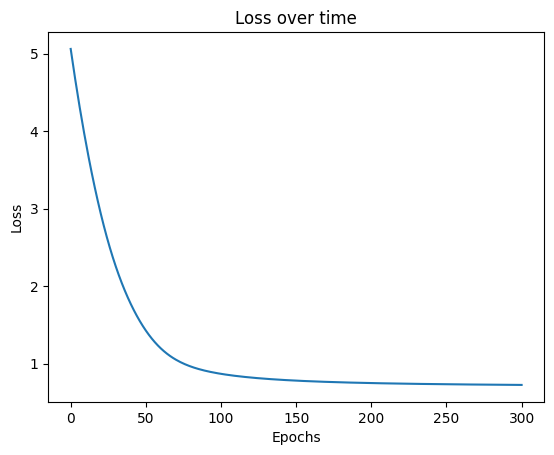

In [15]:
plt.plot(model.loss_curve)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.show()

<a id="visualization"></a>
## Visualizations!
To visualize our model, we will get an animation of the word vectors over time, along with the predictions over time. 
- For the predictions, we compare them against the ground truth. The ground truth is simply the actually percentage of the time that a word appears in the context of our given word. 
    - Let's say we have the text "The dog went to the park." We are considering the word dog. 
    - We consider the context "The", "went"  and "to".
    - We find that each are in the context 1/3 of the time, because thats the only time we see the word dog. 
    - In a longer text, we would see dog next to other words, like bone or dig, and the percentage will change. 
- The visualization provides a beautiful depiction of how the model converges to the correct solution.

Not much talked about, but lets see how our loss converges. This shows us how much error the model had throughout training.

In [16]:
# getting colors for our vectors, one per vector so we can easily distinguish the points
def generate_unique_colors(num_colors):
    cmap = plt.get_cmap('tab20')
    return cmap(np.linspace(0, 1, num_colors))

To visualize vectors over time, we simply select our vectors of choice, and find our model states for these vectors. 
- Once we do this, we can update our plot every frame to select the vectors at the next time-step. 
- This gives us the progression of their location in 2D at different times in training. 

In [17]:
def visualize_vectors_over_time(vectors_over_time, index_to_key, num_words=20):
    plt.ioff()

    bound = 2
    vectors_to_display = []
    # Only select vectors for the first num_words words
    for vectors in vectors_over_time:
        vectors_shown = [v for i, v in enumerate(vectors[:num_words]) if index_to_key[i] != 'voices']
        vectors_to_display.append(vectors_shown)

    # Generate unique colors for each word
    num_colors = num_words
    unique_colors = generate_unique_colors(num_colors)

    # Create a figure and axis
    # Initialize scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    sc = ax.scatter([], [])

    # Set the axis limits
    ax.set_xlim(-bound, bound)
    ax.set_ylim(-bound, bound)

    # Create a list to hold the annotations
    annotations = [ax.annotate('', (0, 0)) for _ in range(num_words)]

    def update(frame):
        # Update the scatter plot data for each frame
        sc.set_offsets(vectors_to_display[frame])
        sc.set_color(unique_colors[:len(vectors_to_display[frame])])  # Set colors
        
        # Update annotations with word labels
        for i, (x, y) in enumerate(vectors_to_display[frame]):
            annotations[i].set_text(index_to_key[i])  # Set word label
            annotations[i].set_position((x, y))  # Set position
            annotations[i].set_visible(True)  # Make annotation visible

        return sc, *annotations

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(vectors_to_display), blit=True)

    plt.ion()
    
    return ani


In [18]:
ani = visualize_vectors_over_time(model.vectors_over_time, tokenizer.index_to_key, num_words=30)
ani.save('../../imgs/vectors.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


### Here is our animation, watch the vectors converge!

![Vector Animation](imgs/vectors.gif)

This function simply find every occurence of a given word and find the context distribution we mentioned earlier. This lets us compare both the predictions and ground truth for a given word over time.

In [19]:
def get_context_distribution(dataset, input_id, vocab_size):
    context_accumulator = np.zeros(vocab_size)

    # Iterate through the corpus data
    for sample in dataset:
        if sample['input_id'] == input_id:
            context_accumulator += np.sum(sample['context'], axis=0)

    # Calculate the distribution by normalizing the accumulator
    context_distribution = context_accumulator / context_accumulator.sum()

    return context_distribution

To visualize our predictions, we simply need to update our plot every frame with the prediction at the next iteration. This will simply give us an idea of what the predictions made by the model looked like over time. Since we use gradient descent, you will notice a relatively smooth transition from the initial predictions to the trained predictions.

In [20]:
def visualize_predictions_over_time(pred_over_time, y_true, index_to_key, num_words=20):
    plt.ioff()

    # Create a figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    lines, = ax.plot([], [], color='red', label='Predicted')
    
    ax.plot(y_true, color='green', label='Ground Truth')

    # Set the axis limits
    ax.set_xlim(0, len(index_to_key))
    ax.set_ylim(0, 1)  # Assuming context probabilities are between 0 and 1
    
    # Set labels and legend
    ax.set_xlabel('Vocabulary')
    ax.set_ylabel('Probability')
    ax.set_title('Predicted vs Ground Truth Probability for "treasure"')
    ax.legend(loc='upper right')

    selected_indices = list(np.where(y_true > 0)[0])
    selected_labels = [index_to_key[i] for i in selected_indices]

    ax.set_xticks(selected_indices)
    ax.set_xticklabels(selected_labels, rotation=90)

    def update(frame):
        prob_list = pred_over_time[frame]
        lines.set_data(range(len(prob_list)), prob_list)

        return lines,

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(pred_over_time), blit=True)

    plt.tight_layout()

    plt.ion()

    return ani

Here we can see the truth of which words appear in the context of our word and what percent of the time.

In [21]:
ground_truth = get_context_distribution(dataset, TARGET_ID, len(tokenizer.vocab))
print(ground_truth)

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]


In [22]:
ani = visualize_predictions_over_time(model.predictions_over_time[::10], ground_truth, tokenizer.index_to_key)
ani.save('../../imgs/predictions.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


### Our visualization of the predictions!

![Vector Animation](imgs/predictions.gif)

### Tensorflow Projector
***
Here I write our findings into two tsv files which can be loaded into the [Tensorflow Embedding Projector](https://projector.tensorflow.org/).
- This gives us a great visualization of the embeddings and easy comparison of similar words.
- Follow the link to [My Projector!](https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/chris-caballero/2e058818e161d7362ae51368afa00eb4/raw/76d86fc5e085ca7a2d34b8e30cf4d73047405369/projector-config.json)

In [23]:
np.savetxt('../../data/embeddings.tsv', model.embedding_matrix, delimiter='\t')

# Save the metadata as a TSV file
with open("../../data/metadata.tsv", 'w') as f:
    for item in tokenizer.key_to_index:
        f.write(str(item) + '\n')

<div style="display: flex;">
    <div style="background-color: white; width: 25%; padding: 20px; margin-left: 20px">
        <p style="font-size: 25px; font-weight: 700; text-align: center; color: #b34c69;">
            Similar Words to <em>Adventures</em>
        </p>
        <hr>
        <p style="text-align: center">
            <img src="imgs/similarity.png" width='100%' height='100%'>
        </p>
    </div>
</div>

<a id="discussion"></a>
## Discussion
Well! That is pretty much it for our implementation. I had a great time refactoring my old code in this process and having a clean notebook showing the results.
1. We implemented the data loading and processing, seeing how easy it is to clean our data for training.
2. We went in depth into the model architecture and training methods, and actually implemented our model class and trained it!
3. Lastly, we visualized our findings, seeing the prediction convergence to the ground truth, watching the word vectors move around and witnessing some interesting analog relationships.

***
Thanks so much for checking out this notebook! Check out my other works if you are interested, I hope to have in depth project notebooks for all of them at some point!